# Real-time traffic car detection and tracking using YOLOv11 and DeepSORT

## Import Libraries and datasets

In [40]:
# Import libraries
import os
import shutil
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from skimage.io import imread
import imagesize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from PIL import Image
from ultralytics import YOLO
from IPython.display import Video

In [39]:
!pip install scikit-image imagesize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 46.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-image] [scikit-image]


In [15]:
# Import input images directory and load images
import kagglehub
target_dir = "./data"

# Download latest version
path = kagglehub.dataset_download("farzadnekouei/top-view-vehicle-detection-image-dataset", )

os.makedirs(target_dir, exist_ok=True)

shutil.copytree(path, target_dir, dirs_exist_ok=True)

print(f"Dataset was downloades in:{os.path.abspath(target_dir)}")

Dataset was downloades in:/mnt/e/Development/Python/RL/Self-DrivingCarUsingDDPG/yolo_detect_object/realtime_detect_car/data


In [19]:
# Collect train, val dir address
data_dir = f'{target_dir}/Vehicle_Detection_Image_Dataset'
train_dir = f'{data_dir}/train'
val_dir   = f'{data_dir}/valid'

yaml_path  = f'{data_dir}/data.yaml'

train_dir, val_dir

('./data/Vehicle_Detection_Image_Dataset/train',
 './data/Vehicle_Detection_Image_Dataset/valid')

In [42]:
# Extract the images' paths
def extract_image_paths(data_dir):
    images_dir = f'{data_dir}/images'
    image_paths = []
    for file in os.listdir(images_dir):
        if file.endswith(".png") or file.endswith(".jpg"): 
            image_path = os.path.join(images_dir, file)
            image_paths.append(image_path)

    return image_paths

In [43]:
image_paths = {
    'Training':   extract_image_paths(train_dir),
    'Validation': extract_image_paths(val_dir)
}

In [44]:
def extract_class_names(yaml_path):
    
    with open(yaml_path, 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)
    class_names = data.get('names')
    
    return class_names

## Preview a random instance of the dataset

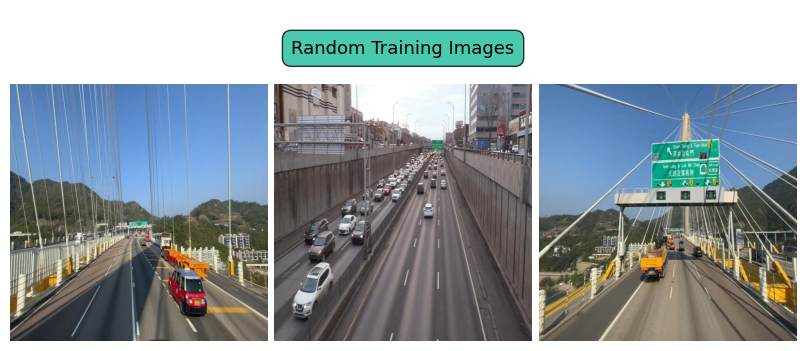

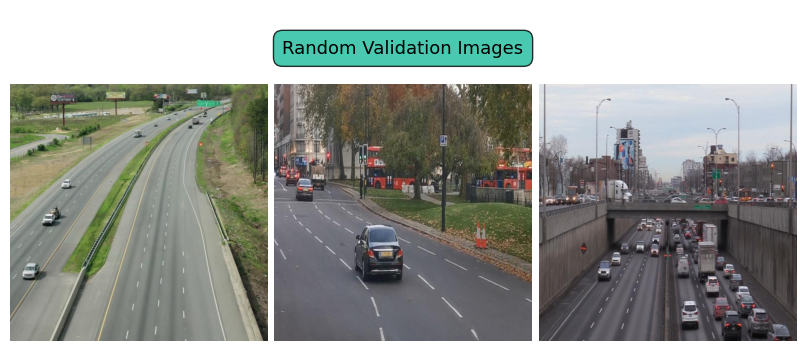

In [62]:
from matplotlib.gridspec import GridSpec
import random
for split_name, paths in image_paths.items():
    
    fig = plt.figure(figsize=(8, 4))
    gs = GridSpec(2, 3, height_ratios=[0.1, 0.95])

    title_ax = fig.add_subplot(gs[0, :])
    title_ax.text(0.5, 0, f"Random {split_name} Images",
                  fontsize=13, ha='center', va='center',
                  bbox=dict(facecolor='#1ABC9C', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))
    title_ax.axis('off')

    for j in range(3):
        ax = fig.add_subplot(gs[1, j])
        random_img = random.choice(paths)
        img = imread(random_img)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout(pad=0.5)
    plt.show()

In [47]:
class_names = extract_class_names(yaml_path=yaml_path)
print(class_names)

['Vehicle']


## Create a YOLO box annotation function

In [68]:
def create_yolo_boxexs(ax, image_path, class_names):
    image_path = os.path.normpath(image_path)
    parts = image_path.split(os.sep) # Split the path base on the sep
    parts[parts.index('images')] = 'labels'
    label_path = os.path.splitext(os.sep.join(parts))[0] + '.txt'
    # Read images
    img = imread(image_path)
    h, w = img.shape[:2]
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for l in lines:
        cls, x_c, y_c, bw, bh = map(float, l.strip().split())
        x_c, y_c, bw, bh = x_c*w, y_c*h, bw*w, bh*h
        x_min, y_min = x_c - bw/2, y_c - bh/2

        color = np.array([1.0, 0.3, 0.3])
        ax.add_patch(plt.Rectangle((x_min, y_min), bw, bh,
                                   edgecolor=color, facecolor='none', linewidth=2))
        ax.text(x_min, max(y_min - 5, 0), class_names[int(cls)],
                color='white', fontsize=8,
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1))

Label format of YOLO:
```
<object-class> <x_center> <y_center> <width> <height>
```

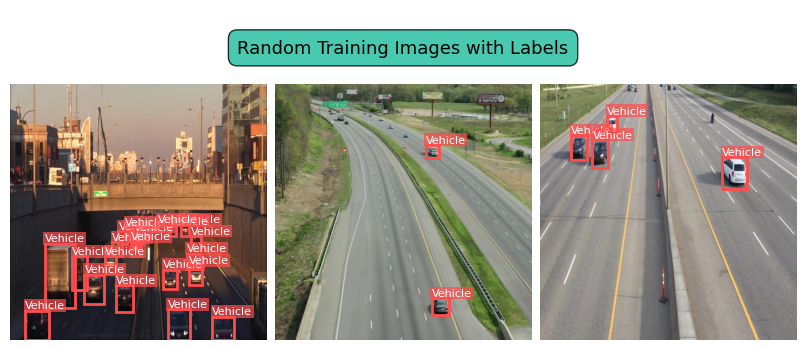

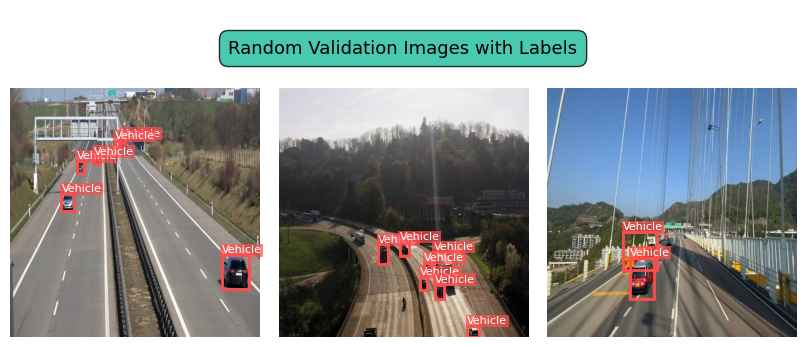

In [69]:
for split_name, paths in image_paths.items():
    fig = plt.figure(figsize=(8, 4))
    gs = GridSpec(2, 3, height_ratios=[0.1, 0.95])

    ax_title = fig.add_subplot(gs[0, :])
    ax_title.text(0.5, 0, f"Random {split_name} Images with Labels",
                  fontsize=13, ha='center', va='center',
                  bbox=dict(facecolor='#1ABC9C', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))
    ax_title.axis('off')

    for j in range(3):
        ax = fig.add_subplot(gs[1, j])
        img_path = random.choice(paths)
        ax.imshow(imread(img_path))
        create_yolo_boxexs(ax, image_path=img_path, class_names=class_names)
        ax.axis('off')

    plt.tight_layout(pad=0.5)
    plt.show()

## Checking data count per dataset split

/tmp/ipykernel_5155/4180915797.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=splits, y=image_counts, palette='viridis', ax=axes[0])


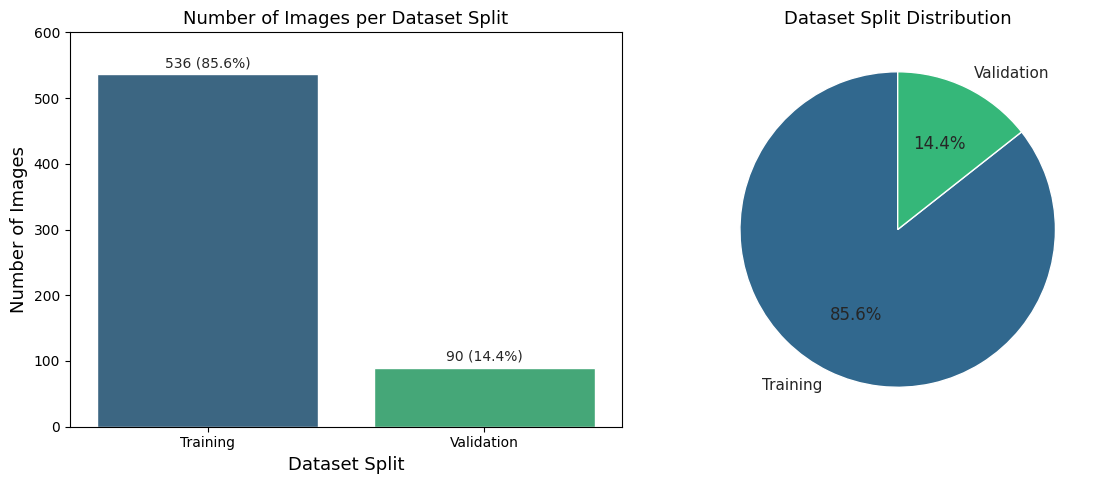

In [74]:
splits = list(image_paths.keys())
image_counts = [len(paths) for paths in image_paths.values()]
total_images = sum(image_counts)

fig, axes = plt.subplots(1, 2, figsize=(12,5))  # 1 hàng, 2 cột

# --- Barplot ---
sns.set_theme(style="darkgrid")
ax = sns.barplot(x=splits, y=image_counts, palette='viridis', ax=axes[0])

for i, count in enumerate(image_counts):
    percent = count / total_images * 100
    ax.text(
        i, count + total_images*0.01,
        f"{count} ({percent:.1f}%)",
        ha='center', va='bottom', fontsize=10
    )

axes[0].set_title('Number of Images per Dataset Split', fontsize=13)
axes[0].set_xlabel('Dataset Split', fontsize=13)
axes[0].set_ylabel('Number of Images', fontsize=13)
axes[0].set_yticks(range(0, 601, 100))

# --- Pie chart ---
colors = sns.color_palette("viridis", len(splits))
axes[1].pie(
    image_counts,
    labels=splits,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
axes[1].set_title("Dataset Split Distribution", fontsize=13)

plt.tight_layout()
plt.show()


### Check the images' dimensions

In [75]:
from collections import Counter
shapes = []

for img_path in (image_paths["Training"] + 
                 image_paths["Validation"]):
    
    width, height = imagesize.get(img_path)
    
    shapes.append((width, height))

shape_counts = Counter(shapes)

In [76]:
for shape, count in shape_counts.most_common():
    print(f"{shape}: {count} images")

(640, 640): 626 images


## Modelling

### Load the YOLOv8 model pre-trained

In [ ]:
# Load a pretrained YOLOv8n model from Ultralytics
model_8v = YOLO('yolov8n.pt')

### Load the YOLOv11 model pre-trained

In [70]:
yolo_variant = 'yolo11s'
model_11v = YOLO(yolo_variant)

In [77]:
image_size = 640
batch_size = 16
epochs = 50
temp_save_dir = 'temp_output_folder'

In [ ]:
training_results = model_11v.train(
    data = yaml_path,
    imgsz = image_size,
    batch = batch_size,
    epochs = epochs,
    lr0 = 0.001,
    optimizer = 'AdamW',
    project = temp_save_dir,
    name = 'train'
)

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data/Vehicle_Detection_Image_Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, pa